# Adag Wrapper

In [3]:
import numpy as np
import math
import os, time, sys
import pickle
from matplotlib import pyplot as plt

import tigramite
import tigramite.data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr

from sklearn.linear_model import LinearRegression

import vector_CD.data_generation.mult_data_gen_methods as mech
import vector_CD.CD_methods.vec_CD_methods as cd
from vector_CD.cond_ind_tests.parcorr_mult_regularized import ParCorrMult
import vector_CD.aggregation_validity.funcs as ff
import vector_CD.aggregation_validity.metrics_ADAG as met

In [41]:
print_graph = False

def calculate(para_setup):
    
    para_setup_string, sam = para_setup
    paras = para_setup_string.split('-')
    paras = [w.replace("'","") for w in paras]
    
    method = str(paras[0])
    score_type = str(paras[1]) 
    data_gen = str(paras[2])
    d_macro = int(paras[3])
    d_micro = int(paras[4])
    T = int(paras[5])
    coeff = float(paras[6])
    auto = float(paras[7])
    contemp_frac = float(paras[8])
    pc_alpha = float(paras[9])
    tau_max = int(paras[10])
    internal_ER = float(paras[11]) #ER: erdos-renyi probability
    external_ER = float(paras[12])
    neg = float(paras[13])
    pca_weight = None
        
    # print(data_gen, d_macro, d_micro, T, coeff, auto, contemp_frac, pc_alpha, tau_max, method, corr_type, reg_type)
    # print("METHOD", method)
    
    #############################################
    ##  Data Generation 
    #############################################    

    range_nan = 5 #number of trials to find a score that isn't NaN
    for ir in range(range_nan):
    
        if 'coarse_dag' in data_gen:
            data, true_graph = mech.data_coarse_dag(data_gen,sam,d_macro,d_micro,coeff,auto,
                                              tau_max,contemp_frac,T,
                                              neg,
                                              internal_ER = internal_ER,
                                              external_ER = external_ER)
        elif 'cbm' in data_gen:
            data, true_graph = mech.data_mrf(d_macro,d_micro, sam, T)  

        elif 'mrf_ts' in data_gen:
            data, true_graph = mech.data_mrf_ts(data_gen,sam,d_macro,d_micro,coeff,auto,
                                              neg,
                                              pca_weight,
                                              tau_max,contemp_frac,T,
                                              internal_er = internal_ER,
                                              external_er = external_ER)   

        elif 'savar' in data_gen:
            data, true_graph = mech.data_savar(data_gen,d_macro,d_micro, sam, T, coeff, auto, contemp_frac, tau_max)   

        computation_time_start = time.time()
        if method == 'vec':                                 
            ############
            # VEC-PC(MCI)
            ############
            cond_ind_test = ParCorrMult(
                                correlation_type = 'gcm_gmb',
                                regularization_model = LinearRegression(),
                                significance = 'shuffle_test',
                                sig_blocklength=1,
                                sig_samples=200)
            vector_vars = cd.vector_vars_from_Narray(d_macro,d_micro)
            dataframe = pp.DataFrame(data, vector_vars = vector_vars, analysis_mode  = 'single')
            pcmci = PCMCI(
                dataframe=dataframe, 
                cond_ind_test=cond_ind_test,
                verbosity=0)
            pcmcires = pcmci.run_pcmciplus(
                tau_min=0,
                tau_max=tau_max,
                pc_alpha=pc_alpha,)
            graph = pcmcires['graph']
            break

        elif 'adag_pca' in method:
            ##################
            # ADAG-PCA-PC(MCI)
            ##################
            score = 0
            m= 0 
            agg_method = "pca_1"
            alpha = float(method.replace('adag_pca_',''))
            # print('alpha_q = ', alpha)    

            while score < alpha and m<d_micro:

                print("adag iteration = ",m)
                data_agg, vector_vars = ff.agg_data_by_method(agg_method, data, d_micro, d_macro)

                if m == 0:
                    vector_vars = None
                    ci_test = 'parcorr'
                else:
                    ci_test = 'parcorr_gcm_gmb'


                sepsets,p_matrix,graph,dag,condsets = ff.pc_mci(data_agg, pc_alpha, tau_max,vector_vars = vector_vars,ci_test=ci_test)
                if score_type == 'ind':
                    nom,den = ff.gen_comp_ind_score(data,p_matrix,sepsets, d_macro, d_micro, pc_alpha, ci_test='parcorr_gcm_gmb')
                elif score_type == 'dep':
                    nom ,den = ff.gen_comp_dep_score(data, graph, condsets, d_macro, d_micro, pc_alpha, ci_test='parcorr_gcm_gmb')
                elif score_type == 'AC':
                    nom_ind,den_ind = ff.gen_comp_ind_score(data,p_matrix,sepsets, d_macro, d_micro, pc_alpha, ci_test='parcorr_gcm_gmb')
                    nom_dep,den_dep = ff.gen_comp_dep_score(data, graph, condsets, d_macro, d_micro, pc_alpha, ci_test='parcorr_gcm_gmb')
                    nom, den = 1/2*(nom_ind+nom_dep) , 1/2*(den_ind+den_dep) 
                else:
                    raise ValueError("Undefined Aggregation Consistency Score")
                
                if den != 0:
                    score = float(nom/den)
                    print('SCORE', score)
                    if score < alpha:
                        m += 1
                        agg_method = "pca_"+str(m)
                    else:
                        break
                
                
                elif den == 0: #NaN condition
                    sam+=1000
                    break

            if den != 0:
                break
                


    computation_time_end = time.time()
    computation_time = computation_time_end - computation_time_start


    if print_graph == True:

        print('True Graph \n +++++++')
        tp.plot_graph(
        graph=true_graph,
        link_colorbar_label='cross-MCI',
        node_colorbar_label='auto-MCI',
        show_autodependency_lags=False
        ); plt.show()

        print('Output Graph \n +++++++')
        tp.plot_graph(
        graph=graph,
        link_colorbar_label='cross-MCI',
        node_colorbar_label='auto-MCI',
        show_autodependency_lags=False
        ); plt.show()

    true_graph = mech.dag_to_cpdag(true_graph, tau_max)

    return{'true_graph':true_graph,
            'graph':graph,
            'computation_time':computation_time
            }

In [42]:
# TODO: Implement an already_there 
##########

def compute_reps(config_list, samples):
    all_configs = dict([(conf, {
        'results':{}, 
        "graphs":{}, 
        "true_graph":{}, 
        "computation_time":{},} ) for conf in config_list])
    job_list = [(conf, i) for i in range(samples) for conf in config_list]
    config_chunks = [job_list]

    def process_chunks(job_id, chunk):
        results = {}
        num_here = len(chunk)
        time_start_process = time.time()
        for isam, config_sam in enumerate(chunk):
            print(config_sam,'\n------------\n')
            results[config_sam] = calculate(config_sam)
        return results

    for job_id, chunk in enumerate(config_chunks):
        tmp = process_chunks(job_id, chunk)
        for conf_sam in list(tmp.keys()):
            config = conf_sam[0]
            sample = conf_sam[1]
            all_configs[config]['results'][sample] = tmp[conf_sam]
        
    return all_configs

In [43]:
def save_results(all_configs):
    
    for conf in list(all_configs.keys()):

        all_configs[conf]['graphs'] = np.zeros((samples, ) + all_configs[conf]['results'][0]['graph'].shape, dtype='<U3')
        all_configs[conf]['true_graphs'] = np.zeros((samples, ) + all_configs[conf]['results'][0]['true_graph'].shape, dtype='<U3')
        all_configs[conf]['computation_time'] = [] 


        for i in list(all_configs[conf]['results'].keys()):
            all_configs[conf]['graphs'][i] = all_configs[conf]['results'][i]['graph']
            all_configs[conf]['true_graphs'][i] = all_configs[conf]['results'][i]['true_graph']
            all_configs[conf]['computation_time'].append(all_configs[conf]['results'][i]['computation_time'])


        del all_configs[conf]['results']

        if os.path.expanduser('~') == '/Users/urmininad':
            file_name = os.path.expanduser('~') + '/Documents/Python/aggregation_validity/interimresults_ADAG/%s' %(conf)
            file_name_met = os.path.expanduser('~') + '/Documents/Python/aggregation_validity/metrics_ADAG/%s' %(conf)
        else:
            print("wrong path for running locally")

        print("dump ", file_name.replace("'", "").replace('"', '') + '.dat')
        file = open(file_name.replace("'", "").replace('"', '') + '.dat', 'wb')
        pickle.dump(all_configs[conf], file, protocol=-1)        
        file.close()

        # Directly compute metrics and save in much smaller dict
        para_setup_str = tuple(conf.split("-"))
        metrics = met.get_counts(para_setup_str)

        if metrics is not None:
            for metric in metrics:
                if metric != 'computation_time':
                    print(f"{metric:30s} {metrics[metric][0]: 1.2f} +/-{metrics[metric][1]: 1.2f} ")
                else:
                    print(f"{metric:30s} {metrics[metric][0]: 1.2f} +/-[{metrics[metric][1][0]: 1.2f}, {metrics[metric][1][1]: 1.2f}]")

            print("Metrics dump ", file_name_met.replace("'", "").replace('"', '') + '_metrics.dat')
            file = open(file_name_met.replace("'", "").replace('"', '') + '_metrics.dat', 'wb')
            pickle.dump(metrics, file, protocol=-1)        
            file.close()

        else:
            print("Metrics is None, CHECK!!!!!")

## Run Experiments

In [44]:
anyconfigurations = [] 
for method in ['adag_pca_0.9']:#['vec', 'adag_pca_0.7']:
    for score_type in ['ind']: #['AC']:
        for data_gen in ['mrf_ts']:  
            for d_macro in [5]:
                for d_micro in [20]: #[50]   
                    for coeff in [0.5]:
                        for auto in [0.3]:
                            for contemp_frac in [1.]:
                                for T in [20, 50, 100, 150, 200, 250]:#, 300]:
                                    for pc_alpha in [0.01]:
                                        for tau_max in [0]:
                                            for internal_ER in [0.3]:#[0.1,0.3,0.5,0.7,1.0]:
                                                for external_ER in [0.5]:#[1.0, 0.7, 0.5, 0.3, 0.1]: 
                                                    for neg in [1.]:#[0.,0.2,0.4,0.6,0.8,1.]: 
                                                        for pca_weight in ['None']:#[0.,0.1,0.2,0.3,0.4]: 
                                                            para_setup = (method, score_type, data_gen, d_macro, d_micro, T, coeff, auto, contemp_frac, pc_alpha, tau_max, 
                                                                            internal_ER, external_ER, neg, pca_weight)
                                                            name = '%s-'*len(para_setup) % para_setup
                                                            name = name[:-1]
                                                            anyconfigurations += [name]

config_list = anyconfigurations
     
config_list

['adag_pca_0.9-ind-mrf_ts-5-20-20-0.5-0.3-1.0-0.01-0-0.3-0.5-1.0-None',
 'adag_pca_0.9-ind-mrf_ts-5-20-50-0.5-0.3-1.0-0.01-0-0.3-0.5-1.0-None',
 'adag_pca_0.9-ind-mrf_ts-5-20-100-0.5-0.3-1.0-0.01-0-0.3-0.5-1.0-None',
 'adag_pca_0.9-ind-mrf_ts-5-20-150-0.5-0.3-1.0-0.01-0-0.3-0.5-1.0-None',
 'adag_pca_0.9-ind-mrf_ts-5-20-200-0.5-0.3-1.0-0.01-0-0.3-0.5-1.0-None',
 'adag_pca_0.9-ind-mrf_ts-5-20-250-0.5-0.3-1.0-0.01-0-0.3-0.5-1.0-None']

In [45]:
samples = 100 #not sample size, but number of repetitions
all_configs = compute_reps(config_list, samples)

('adag_pca_0.9-ind-mrf_ts-5-20-20-0.5-0.3-1.0-0.01-0-0.3-0.5-1.0-None', 0) 
------------

adag iteration =  0
SCORE 1.0
('adag_pca_0.9-ind-mrf_ts-5-20-50-0.5-0.3-1.0-0.01-0-0.3-0.5-1.0-None', 0) 
------------

adag iteration =  0
SCORE 0.875
adag iteration =  1
SCORE 1.0
('adag_pca_0.9-ind-mrf_ts-5-20-100-0.5-0.3-1.0-0.01-0-0.3-0.5-1.0-None', 0) 
------------

adag iteration =  0
SCORE 0.75
adag iteration =  1
SCORE 0.75
adag iteration =  2
SCORE 0.5714285714285714
adag iteration =  3
SCORE 0.7142857142857143
adag iteration =  4
SCORE 0.7142857142857143
adag iteration =  5
SCORE 0.7142857142857143
adag iteration =  6
SCORE 0.625
adag iteration =  7
SCORE 0.7142857142857143
adag iteration =  8
SCORE 0.5714285714285714
adag iteration =  9
SCORE 0.5714285714285714
adag iteration =  10
SCORE 0.5714285714285714
adag iteration =  11
SCORE 0.5714285714285714
adag iteration =  12
SCORE 0.5
adag iteration =  13
SCORE 0.8571428571428571
adag iteration =  14
SCORE 0.875
adag iteration =  15
SCORE

In [46]:
save_results(all_configs)

dump  /Users/urmininad/Documents/Python/aggregation_validity/interimresults_ADAG/adag_pca_0.9-ind-mrf_ts-5-20-20-0.5-0.3-1.0-0.01-0-0.3-0.5-1.0-None.dat
########## /Users/urmininad/Documents/Python/aggregation_validity/interimresults_ADAG/adag_pca_0.9-ind-mrf_ts-5-20-20-0.5-0.3-1.0-0.01-0-0.3-0.5-1.0-None
load   /Users/urmininad/Documents/Python/aggregation_validity/interimresults_ADAG/adag_pca_0.9-ind-mrf_ts-5-20-20-0.5-0.3-1.0-0.01-0-0.3-0.5-1.0-None.dat
adj_anylink_precision           0.94 +/- 0.02 
adj_anylink_recall              0.24 +/- 0.02 
all_precision                   0.02 +/- 0.02 
all_recall                      0.00 +/- 0.00 
edgemarks_anylink_precision     0.57 +/- 0.04 
edgemarks_anylink_recall        0.15 +/- 0.01 
unoriented_anylink              0.49 +/- 0.03 
conflicts_anylink               0.00 +/- 0.00 
computation_time                0.08 +/-[ 0.03,  0.23]
Metrics dump  /Users/urmininad/Documents/Python/aggregation_validity/metrics_ADAG/adag_pca_0.9-ind-mrf_ts-5-

## Retrieve Metrics

In [47]:
folder_name = os.path.expanduser('~') + '/Documents/Python/aggregation_validity/metrics_ADAG/'
def get_metrics_from_config(para_setup):
    file_name = folder_name + para_setup + '_metrics'
    try:
        results = pickle.load(open(file_name.replace("'", "").replace('"', '') + '.dat', 'rb'), encoding='latin1')
    except:
        print("failed  ", file_name.replace("'", "").replace('"', '') + '.dat')
        return None
    return results

In [48]:
results = get_metrics_from_config(config_list[0])
results

{'adj_anylink_precision': (0.937984496124031, 0.019145458146402016),
 'adj_anylink_recall': (0.242, 0.01505375700614302),
 'all_precision': (0.015503875968992248, 0.015849351081208052),
 'all_recall': (0.004, 0.00421027315028372),
 'edgemarks_anylink_precision': (0.5736434108527132, 0.04119862830998042),
 'edgemarks_anylink_recall': (0.148, 0.014340027893975659),
 'unoriented_anylink': (0.486, 0.030283287470154234),
 'conflicts_anylink': (0.0, 0.0),
 'computation_time': (0.08252792596817017, array([0.03282847, 0.23143743]))}

## Sample Plot

In [137]:
plot_type = 'adj_anylink_recall'#'edgemarks_anylink_recall'#'adj_anylink_precision'#'adj_anylink_precision'
sample_range = [100, 200, 500, 1000]
adag = []
vec = []
for conf in config_list:
    results = get_metrics_from_config(conf)
    if 'adag' in tuple(conf.split("-"))[0]:
        adag.append(results[plot_type])
    elif 'vec' in tuple(conf.split("-"))[0]:
        vec.append(results[plot_type])

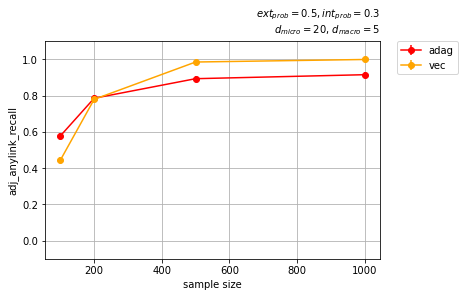

In [138]:
save = False


plt.errorbar(sample_range, np.array(adag)[:,0], yerr= np.array(adag)[:,1] ,label = 'adag', color = 'red',marker = 'o', linestyle='solid')
plt.errorbar(sample_range, np.array(vec)[:,0], yerr= np.array(vec)[:,1] ,label = 'vec', color = 'orange',marker = 'o', linestyle='solid')
plt.ylim(-0.1, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.figtext(0.9, 1., r"$ext_{prob}=%s, int_{prob}=%s$" %(external_ER, internal_ER) 
        +"\n" + r"$d_{micro}=%s$, $d_{macro}=%s$" %(d_micro,d_macro),
            fontsize=10, ha='right', va='top')
plt.xlabel('sample size')
plt.ylabel(plot_type)
plt.grid(True)


if save == True:
    save_folder = os.path.expanduser('~') + '/Documents/Python/aggregation_validity/figures/'
    para_setup = ('ADAG', d_macro, d_micro, external_ER, internal_ER)
    save_suffix = '%s-'*len(para_setup) % para_setup
    save_type = 'pdf'
    plt.savefig(save_folder + '%s.%s' %(save_suffix, save_type),bbox_inches = 'tight')

## Plot Panels for Paper

In [78]:
def color_picker(method,score_type):
    if 'vec' in method:
        # if 'ind' in score_type:
        #     return 'lightgreen'
        # elif 'dep' in score_type:
        #     return'lightcoral'
        return 'lightgreen'

    elif 'adag' in method:
        # if 'ind' in score_type:
        #     return 'green' 
        # elif 'dep' in score_type:
        #     return 'darkred'
        # return 'green'
        # return 'black'
        return 'darkred'#'deeppink'#'mediumvioletred'
        
        
def color_picker_all(method,score_type):
    if 'vec' in method:
        if 'ind' in score_type:
            return 'lightgreen'
        elif 'dep' in score_type:
            return 'royalblue'#'lightgreen'#'lightcoral'
    elif 'adag' in method:
        if 'ind' in score_type:
            return 'red' 
        elif 'dep' in score_type:
            return 'chocolate'
        elif 'AC' in score_type:
            return 'orange'
    
    
    
    #'lightblue'#'lightgreen'#'orange' #'blue'  # (207.0/255, 4.0/255, 4.0/255, 0.5)
    # elif 'avg' in method:
    #     return 'red' #'red','yellow','orange'
    # else:
    #     return 'grey'

In [79]:
save_folder = os.path.expanduser('~') + '/Documents/Python/aggregation_validity/figures/'
which = 'sample_size'

    
if which == 'sample_size':
    ##################
    # Plotting globals
    ##################
    d_macro = 5
    d_micro = 20#50 #20
    coeff = 0.5
    auto = 0.3
    contemp_frac = 1.0
    pc_alpha = 0.01
    tau_max = 0
    internal_ER = 0.3 
    external_ER = 0.5    
    neg = 1.0
    pca_weight = 'None'
    score_type = 'ind'#'ind'#'dep'#'ind'
    scores = ['ind', 'dep', 'AC']
    ####################
    # Plotting local args
    ####################
    paras = [20,50,100,150,200,250] # [50,100,150,200,250,300]
    plots = ['adj_anylink_precision', 'adj_anylink_recall','edgemarks_anylink_precision', 'edgemarks_anylink_recall'] #, 'unoriented_anylink','computation_time']
    methods = ['vec', 'adag_pca_0.9', 'adag_pca_0.7']#['vec', 'adag_pca_0.7']
    data_gen = 'mrf_ts'


### Each Score Individually

In [39]:
###############
# Plotting FUNC
###############

def generate_plots(which,
                   paras,
                   plots, 
                   methods, 
                   mech,
                   save = 'no'):
    if len(plots)==2:
        fig, (axs) = plt.subplots(1,2, figsize=(12,  4))
        axs = axs.ravel()
    elif len(plots) == 4:
        fig, (axs) = plt.subplots(2,2, figsize=(12,  8))
        axs = axs.ravel()
    elif len(plots) == 6:
        fig, (axs) = plt.subplots(3,2, figsize=(10,  10))
        axs = axs.ravel()
    elif len(plots) == 8:
        fig, (axs) = plt.subplots(4,2, figsize=(8,  8))
        axs = axs.ravel()
    else:
        raise ValueError("Enter correct subplots dimensions")
        
    
    y_list = np.zeros((len(methods),len(plots),len(paras)))
    yerr_list = np.zeros((len(methods),len(plots),len(paras)))
    x_list = np.zeros(len(paras))
    
    for method in methods:
        for para in paras:
            para_plot = paras.index(para) + methods.index(method)/float(len(methods))*.6
            x_list[paras.index(para)] = para_plot
            
            if which == 'sample_size':
                score_type_here = score_type
                data_gen_here = data_gen
                d_macro_here = d_macro
                d_micro_here = d_micro
                coeff_here = coeff
                auto_here = auto
                contemp_frac_here = contemp_frac
                pc_alpha_here = pc_alpha
                tau_max_here = tau_max
                internal_ER_here = internal_ER
                external_ER_here = external_ER
                neg_here = neg
                pca_weight_here = pca_weight
                
                para_setup = (method, score_type_here, data_gen_here, d_macro_here, d_micro_here, para,
                              coeff_here, auto_here, contemp_frac_here, pc_alpha_here, tau_max_here, 
                              internal_ER_here, external_ER_here, neg_here, pca_weight_here)

                name = '%s-'*len(para_setup) % para_setup
                para_setup = name[:-1]
                metrics_dict = get_metrics_from_config(para_setup)
            

                            
            if metrics_dict is None:
                raise ValueError('metrics dict is empty for config:', para_setup)
            else:                
                for j, plot_type in enumerate(plots):
                    # axs[j].errorbar(para_plot, *metrics_dict[plot_type], capsize = .5, 
                    #                 color=color_picker(method),marker = 'o', linestyle='solid')
                    # axs[j].set_title(plot_type, fontsize=10,pad = 2)
                    axs[j].grid(True)     
                    if plot_type == 'computation_time':
                        y_list[methods.index(method),j,paras.index(para)] =  metrics_dict[plot_type][0]
                        yerr_list[methods.index(method),j,paras.index(para)] = metrics_dict['computation_time'][1][0]#.reshape(2, 1)
                    else:
                        y_list[methods.index(method),j,paras.index(para)], yerr_list[methods.index(method),j,paras.index(para)] = metrics_dict[plot_type]
            
        for i,ax in enumerate(axs):
            if which == 'sample_size':  
                ax.errorbar(x_list, y_list[methods.index(method), i], yerr = yerr_list[methods.index(method), i],
                            color= color_picker(method,score_type_here), marker = 'o', linestyle='solid')
                ax.set_xlim(-0.5, len(paras)-0.5)  
                ax.set_ylim(0., 1.1)
                if 'computation_time' in plots:
                    if i == plots.index('computation_time'):
                        ax.set_ylim(-0.2, 3.9)  
                    else:
                        ax.set_ylim(0., 1.1)  
                ax.xaxis.set_ticks([paras.index(p) for p in paras] )
                ax.xaxis.set_ticklabels([str(p) for p in paras] )
                    
        if which == 'sample_size':
            plt.errorbar([], [], linestyle='solid',
                            capsize=.5, label=method,
                            color=color_picker(method, score_type_here), marker='o')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            
            plt.figtext(0.5, 0.07, r"Sample Size", fontsize=12,
                horizontalalignment='center', va='bottom')
            # plt.figtext(1., 1.05, r"$int_{prob}=%s, cross_{prob}=%s$" %(internal_ER, external_ER) 
            #                     +"\n" + r"$\tau_{\max}=%d$, $d_{micro}=%s$, $d_{macro}=%s$" %(tau_max,d_micro,d_macro),
            #  fontsize=12, ha='right', va='top')
            plt.figtext(0.6, 0.96, r"$d_{micro}=%s$, $d_{macro}=%s$" %(d_micro,d_macro)
                                +"\n" + r"$int_{prob}=%s, ext_{prob}=%s$" %(internal_ER, external_ER),
             fontsize=12, bbox=dict(boxstyle='round', fc='w'), ha='right', va='top')
            
            para_setup_name = ('ADAG_wo_title',score_type_here,which,data_gen_here,method,
                          d_macro_here, d_micro_here, coeff_here, auto_here, contemp_frac_here, pc_alpha_here, tau_max_here, 
                          internal_ER_here, external_ER_here, neg_here, pca_weight_here)
            save_suffix = '%s-'*len(para_setup_name) % para_setup_name
            
            
        
    if save == 'yes':
        save_type = 'pdf'
        fig.savefig(save_folder + '%s.%s' %(save_suffix, save_type),bbox_inches = 'tight')


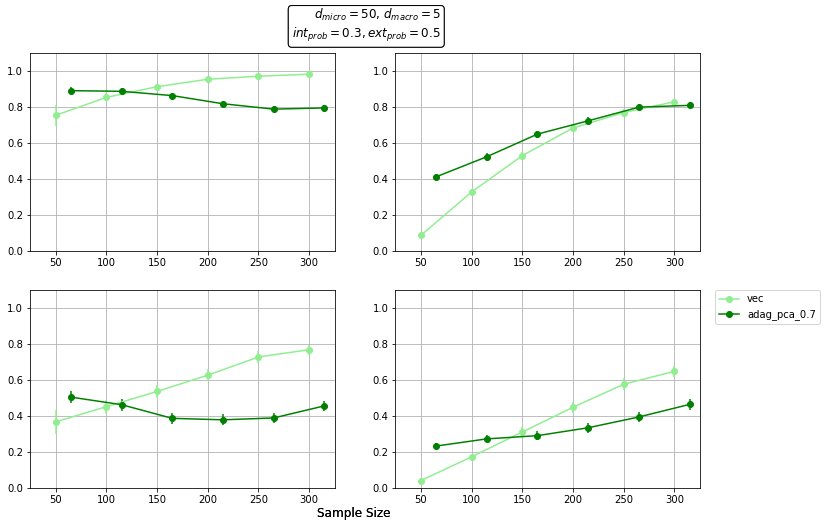

In [288]:
generate_plots(which,
                   paras,
                   plots, 
                   methods, 
                   mech,
              save= 'no')

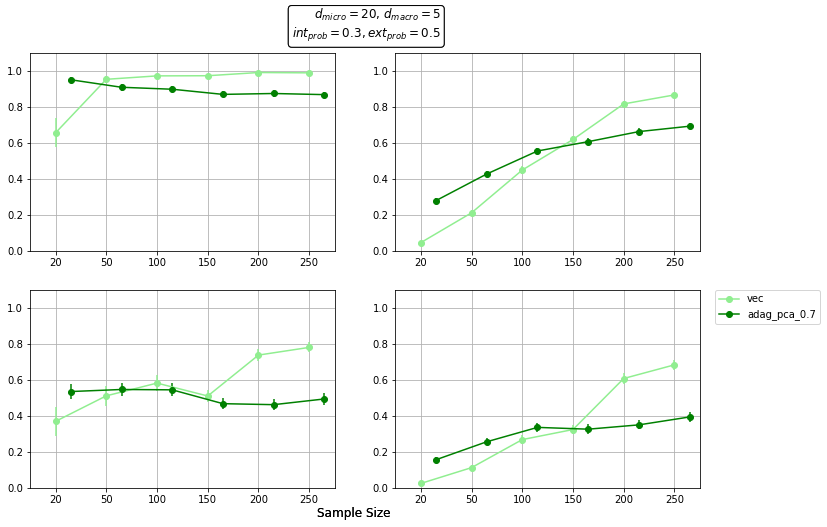

In [37]:
generate_plots(which,
                   paras,
                   plots, 
                   methods, 
                   mech,
              save= 'no')

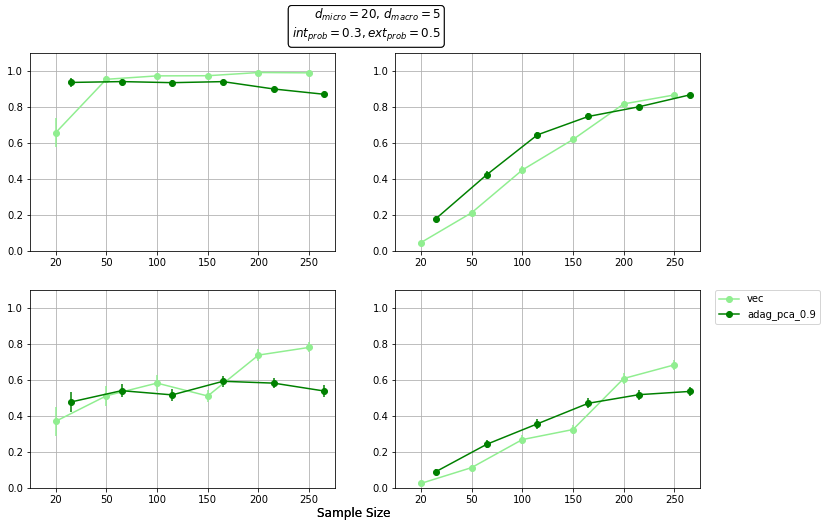

In [40]:
generate_plots(which,
                   paras,
                   plots, 
                   methods, 
                   mech,
              save= 'no')

### Both scores together

In [82]:
###############
# Plotting FUNC
###############

def generate_plots_all(which,
                   paras,
                   plots, 
                   methods, 
                   scores,
                   mech,
                   save = 'no'):
    if len(plots)==2:
        fig, (axs) = plt.subplots(1,2, figsize=(12,  4))
        axs = axs.ravel()
    elif len(plots) == 4:
        fig, (axs) = plt.subplots(2,2, figsize=(12,  8))
        axs = axs.ravel()
    elif len(plots) == 6:
        fig, (axs) = plt.subplots(3,2, figsize=(10,  10))
        axs = axs.ravel()
    elif len(plots) == 8:
        fig, (axs) = plt.subplots(4,2, figsize=(8,  8))
        axs = axs.ravel()
    else:
        raise ValueError("Enter correct subplots dimensions")
        
    
    y_list = np.zeros((len(methods),len(plots),len(paras)))
    yerr_list = np.zeros((len(methods),len(plots),len(paras)))
    x_list = np.zeros(len(paras))
    
    for method in methods:
        for score in scores:
            if method == 'vec' and (score == 'ind' or score == 'AC'):
                pass
            elif method == 'adag_pca_0.9' and (score == 'dep' or score == 'AC'):
                pass
            else:
                for para in paras:
                    para_plot = paras.index(para) + methods.index(method)/float(len(methods))*.6
                    x_list[paras.index(para)] = para_plot

                    if which == 'sample_size':
                        # score_type_here = score_type
                        data_gen_here = data_gen
                        d_macro_here = d_macro
                        d_micro_here = d_micro
                        coeff_here = coeff
                        auto_here = auto
                        contemp_frac_here = contemp_frac
                        pc_alpha_here = pc_alpha
                        tau_max_here = tau_max
                        internal_ER_here = internal_ER
                        external_ER_here = external_ER
                        neg_here = neg
                        pca_weight_here = pca_weight

                        para_setup = (method, score, data_gen_here, d_macro_here, d_micro_here, para,
                                      coeff_here, auto_here, contemp_frac_here, pc_alpha_here, tau_max_here, 
                                      internal_ER_here, external_ER_here, neg_here, pca_weight_here)

                        name = '%s-'*len(para_setup) % para_setup
                        para_setup = name[:-1]
                        metrics_dict = get_metrics_from_config(para_setup)



                    if metrics_dict is None:
                        raise ValueError('metrics dict is empty for config:', para_setup)
                    else:                
                        for j, plot_type in enumerate(plots):
                            # axs[j].errorbar(para_plot, *metrics_dict[plot_type], capsize = .5, 
                            #                 color=color_picker(method),marker = 'o', linestyle='solid')
                            # axs[j].set_title(plot_type, fontsize=10,pad = 2)
                            axs[j].grid(True)     
                            if plot_type == 'computation_time':
                                y_list[methods.index(method),j,paras.index(para)] =  metrics_dict[plot_type][0]
                                yerr_list[methods.index(method),j,paras.index(para)] = metrics_dict['computation_time'][1][0]#.reshape(2, 1)
                            else:
                                y_list[methods.index(method),j,paras.index(para)], yerr_list[methods.index(method),j,paras.index(para)] = metrics_dict[plot_type]

                for i,ax in enumerate(axs):
                    if which == 'sample_size':
                        if 'vec' in method:
                            ax.errorbar(x_list, y_list[methods.index(method), i], yerr = yerr_list[methods.index(method), i],
                                    color= color_picker_all(method,score), marker = 'o', linestyle='dashed')
                        elif method == 'adag_pca_0.9':
                            ax.errorbar(x_list, y_list[methods.index(method), i], yerr = yerr_list[methods.index(method), i],
                                    color= color_picker(method,score), marker = 'o', linestyle='solid')
                        else:
                            ax.errorbar(x_list, y_list[methods.index(method), i], yerr = yerr_list[methods.index(method), i],
                                    color= color_picker_all(method,score), marker = 'o', linestyle='solid')
                            
                        ax.set_xlim(-0.5, len(paras)-0.5)  
                        ax.set_ylim(0., 1.1)
                        if 'computation_time' in plots:
                            if i == plots.index('computation_time'):
                                ax.set_ylim(-0.2, 3.9)  
                            else:
                                ax.set_ylim(0., 1.1)  
                        ax.xaxis.set_ticks([paras.index(p) for p in paras] )
                        ax.xaxis.set_ticklabels([str(p) for p in paras] )
                    
                if which == 'sample_size':
                    if 'vec' in method:
                        plt.errorbar([], [], linestyle='solid',
                                        capsize=.5, label=method+'tor PC',
                                        color=color_picker_all(method, score), marker='o')
                    elif method == 'adag_pca_0.9':
                        plt.errorbar([], [], linestyle='solid',
                                        capsize=.5, label='adag_pca+'+score+'_score=0.9' ,
                                        color=color_picker(method, score), marker='o')
                    else:
                        plt.errorbar([], [], linestyle='solid',
                                        capsize=.5, label='adag_pca+'+score+'_score=0.7' ,
                                        color=color_picker_all(method, score), marker='o')

                        
                        
                    plt.legend(bbox_to_anchor=(0.15, 0.95), loc='upper left', borderaxespad=0.)

                    plt.figtext(0.5, 0.07, r"Sample Size", fontsize=12,
                        horizontalalignment='center', va='bottom')
                    # plt.figtext(1., 1.05, r"$int_{prob}=%s, cross_{prob}=%s$" %(internal_ER, external_ER) 
                    #                     +"\n" + r"$\tau_{\max}=%d$, $d_{micro}=%s$, $d_{macro}=%s$" %(tau_max,d_micro,d_macro),
                    #  fontsize=12, ha='right', va='top')
                    plt.figtext(0.6, 0.96, r"$d_{micro}=%s$, $d_{macro}=%s$" %(d_micro,d_macro)
                                        +"\n" + r"$int_{dens.}=%s, ext_{dens.}=%s$" %(internal_ER, external_ER),
                     fontsize=12, bbox=dict(boxstyle='round', fc='w'), ha='right', va='top')

                    para_setup_name = ('ADAG_higher_score_wo_title',score,which,data_gen_here,method,
                                  d_macro_here, d_micro_here, coeff_here, auto_here, contemp_frac_here, pc_alpha_here, tau_max_here, 
                                  internal_ER_here, external_ER_here, neg_here, pca_weight_here)
                    save_suffix = '%s-'*len(para_setup_name) % para_setup_name
            
            
        
    if save == 'yes':
        save_type = 'pdf'
        fig.savefig(save_folder + '%s.%s' %(save_suffix, save_type),bbox_inches = 'tight')

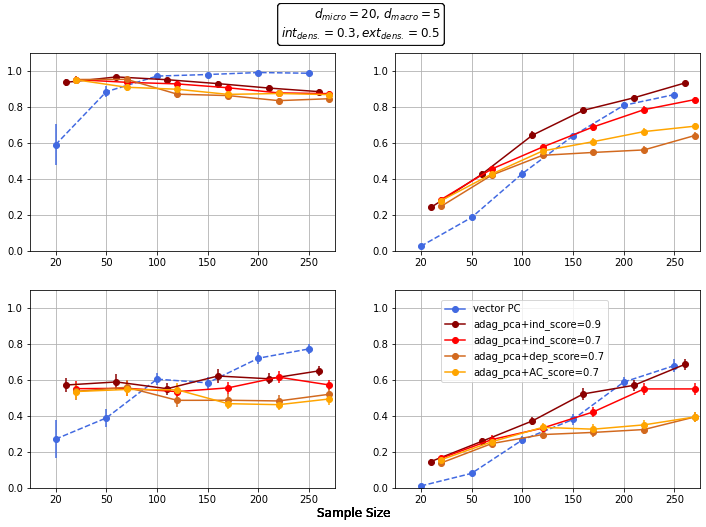

In [83]:
generate_plots_all(which,
                   paras,
                   plots, 
                   methods, 
                   scores,
                   mech,
              save= 'no')

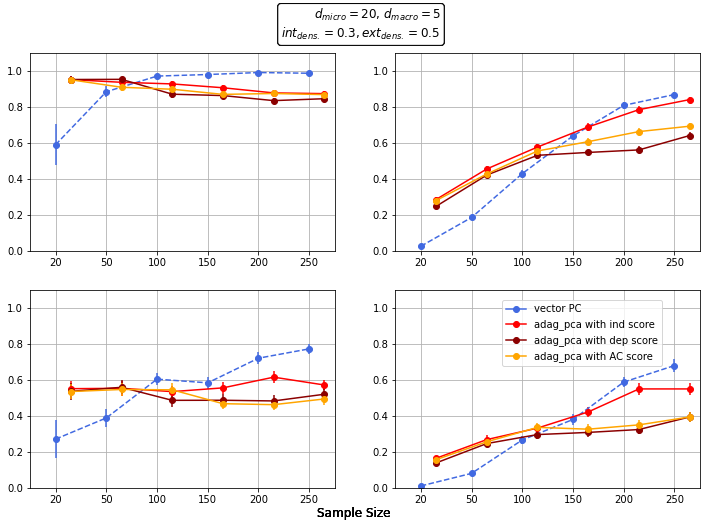

In [517]:
generate_plots_all(which,
                   paras,
                   plots, 
                   methods, 
                   scores,
                   mech,
              save= 'no')

## SAVAR

#### TODO:
- Why is ind_score so low for SAVAR data gen?
    - Maybe because pc_mci only has pcmci_plus? CHANGE~! 
        - Run_pcmci doesnt have SEPSETS!! (needed for ind_score)
            - Keeping pcmciplus only discover contemp links (both for vector and ADAG)
    

In [67]:
import numpy as np
import math
import os, time, sys
from itertools import combinations,product
import pickle
from matplotlib import pyplot as plt

import tigramite
import tigramite.data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr

from sklearn.linear_model import LinearRegression

import mult_data_gen_methods as mech
import vec_CD_methods as cd
from parcorr_mult_regularized import ParCorrMult
import funcs as ff
import metrics_ADAG as met
from pcmci_dep_score import PCMCI as pcmci_condsets

In [431]:
def _get_sepsets(d_macro, tau_min, tau_max):
    """Returns initial sepsets.

    Parameters
    ----------
    tau_min : int, optional (default: 0)
        Minimum time lag to test.
    tau_max : int, optional (default: 1)
        Maximum time lag. Must be larger or equal to tau_min.

    Returns
    -------
    sepsets : dict
        Initialized sepsets.
    """
    sepsets = dict([(((i, -tau), j), [])
                   for tau in range(tau_min, tau_max + 1)
                   for i in range(d_macro)
                   for j in range(d_macro)])

    return sepsets

def pcmci_sepsets(graph, tau_min = 1):
    
    d_macro, d_macro, tau_max_plus_one = graph.shape
    tau_max = int(tau_max_plus_one - 1)
    sepsets = _get_sepsets(d_macro, tau_min, tau_max)
    parents = dict([(j, []) for j in range(d_macro)])
    
    for (i, j, tau) in zip(*np.where(graph=='-->')):
        tau = int(tau)
        parents[j].append((i, -tau))
    
    for (i, j) in product(range(d_macro), range(d_macro)):
        for abstau in range(tau_min, tau_max + 1):
            if graph[i, j, abstau] == "":
                if abstau == 0:
                    sepsets[((i, 0), j)] = sepsets[
                        ((j, 0), i)] = parents[j]+parents[i]
                else:
                    sepsets[((i, -abstau), j)] = parents[j] # in time-series case, parents of the 'later' variable is a sufficienct condtioning set
                    
    return sepsets 

def vec_pcmci_no_contemp(data, d_macro, d_micro, cond_ind_test, tau_max, pc_alpha, tau_min = 1):
    
    vector_vars = cd.vector_vars_from_Narray(d_macro,d_micro)
    dataframe = pp.DataFrame(data, vector_vars = vector_vars, analysis_mode  = 'single')
    pcmci = PCMCI(
        dataframe=dataframe, 
        cond_ind_test=cond_ind_test,
        verbosity=0)
    pcmcires = pcmci.run_pcmci(
        tau_min=tau_min,
        tau_max=tau_max,
        pc_alpha=pc_alpha,)
    graph = pcmcires['graph']
    return graph

def pcmci_aggscore_no_contemp(data_agg, pc_alpha, tau_max, tau_min = 1, vector_vars = None, ci_test = 'parcorr_gcm_gmb', verbosity = 0):
    
    # PC(MCI) on aggregated data without contemp links
    
    if vector_vars ==None:
        dataframe = pp.DataFrame(data_agg, analysis_mode = 'single')
        parcorr = ParCorr(significance='analytic')
        ci_test = parcorr
        
    else: 
        dataframe  =  pp.DataFrame(data_agg, vector_vars = vector_vars, analysis_mode = 'single')
        
        if 'parcorr_maxcorr' in ci_test:
            ci_test = ParCorrMult(significance='analytic')
        elif ci_test == 'parcorr_gcm_gmb':
            ci_test = ParCorrMult(
                        correlation_type = 'gcm_gmb',
                        regularization_model = LinearRegression(),
                        significance = 'shuffle_test',
                        sig_blocklength=1,
                        sig_samples=200)
        else: 
            raise ValueError("Multivariate CI test not included in suite")
            

    pcmci = PCMCI(
        dataframe=dataframe, 
        cond_ind_test=ci_test,
        verbosity=verbosity)

    results = pcmci.run_pcmci(tau_min= tau_min, tau_max=tau_max, pc_alpha=pc_alpha)
    p_matrix = results['p_matrix']
    graph = results['graph']
    sepsets = pcmci_sepsets(graph, tau_min) 
    
    # val_matrix = results['val_matrix']
    # variable_order = np.argsort(
    #                             np.abs(val_matrix).sum(axis=(0,2)))[::-1]        
    # pcmci_base = PCMCIbase(
    #     dataframe=dataframe, 
    #     cond_ind_test=ci_test,
    #     verbosity=verbosity)
    # dag = pcmci_base._get_dag_from_cpdag(graph, variable_order)

    pcmci_depscore = pcmci_condsets(
        dataframe=dataframe, 
        cond_ind_test=ci_test,
        verbosity=verbosity)

    results_condsets = pcmci_depscore.condsets_for_depscore(mode='contemp_conds',pc_alpha=pc_alpha,tau_max=tau_max)
    condsets = results_condsets['condsets']

        # condsets = pcmci_dep_score.condsets_for_depscore(mode='contemp_conds',pc_alpha=pc_alpha,tau_max=tau_max)
    
    return sepsets,p_matrix,graph,condsets

In [69]:
d_macro = 3
d_micro = 49 #20
T = 500
coeff = 0.5
auto = 0.3
contemp_frac = 0.
pc_alpha = 0.01
tau_min = 1
tau_max = 1
score_type = 'ind'
methods = ['vec','adag_pca_0.7'] #['vec'] #['adag_pca_0.7'] # 'vec'
data_gen = 'savar'

savar_reps  = 20
sam =  33
# output_dict = {'vec':[], 'adag_pca_0.7':[]}

In [432]:
def adag_pca_savar(d_macro, d_micro, T, coeff, auto, contemp_frac,
                   pc_alpha, tau_min, tau_max,score_type, 
                   methods, data_gen,
                   savar_reps,sam,
                   range_nan = 7, #number of trials to find a score that isn't NaN
                   print_true_graph = True,
                   print_output_graph = False):
    
    output_dict = {x: list() for x in methods}
    
    data, true_graph = mech.data_savar(data_gen,d_macro,d_micro, sam, T, coeff, auto, contemp_frac, tau_max) 
    true_graphs = np.repeat(true_graph.reshape(1, d_macro,d_macro,tau_max + 1), savar_reps, axis=0)

    if print_true_graph == True:
        print('True Graph \n ==========')
        tp.plot_time_series_graph(
                    figsize=(6, 4),
                    graph=true_graph,
                    link_colorbar_label='MCI',
                    ); plt.show()

    for rep in range(savar_reps):
        print('\n ====== \n REP', rep,  '\n =======')
        for method in methods:
            for ir in range(range_nan):
                
                computation_time_start = time.time()
                if method == 'vec':   
                    print('\n +++++ \n vec \n +++++')
                    ############
                    # VEC-PC(MCI)
                    ############
                    
                    cond_ind_test = ParCorrMult(
                                        correlation_type = 'gcm_gmb',
                                        regularization_model = LinearRegression(),
                                        significance = 'shuffle_test',
                                        sig_blocklength=1,
                                        sig_samples=200)
                    
                    graph = vec_pcmci_no_contemp(data, d_macro, d_micro, cond_ind_test, tau_max, pc_alpha,tau_min)
                    output_dict[method].append(graph)
                    break

                elif 'adag_pca' in method:
                    ##################
                    # ADAG-PCA-PC(MCI)
                    ##################
                    score = 0
                    m= 0 
                    agg_method = "pca_1"
                    alpha = float(method.replace('adag_pca_',''))
                    # print('$\\alpha_q $ = ', alpha, '\n--------')    
                    print('No NaN run', ir)

                    while score < alpha and m<d_micro:
                        print("adag iteration = ",m)
                        data_agg, vector_vars = ff.agg_data_by_method(agg_method, data, d_micro, d_macro)
                        if m == 0:
                            vector_vars = None
                            ci_test = 'parcorr'
                        else:
                            ci_test = 'parcorr_gcm_gmb'

                        sepsets,p_matrix,graph,condsets = pcmci_aggscore_no_contemp(data_agg, pc_alpha, tau_max, tau_min = tau_min, vector_vars = vector_vars,ci_test=ci_test)
                        
                        if score_type == 'ind':
                            nom,den = ff.gen_comp_ind_score(data,p_matrix,sepsets, d_macro, d_micro, pc_alpha, ci_test='parcorr_gcm_gmb',tau_min=tau_min)
                        elif score_type == 'dep':
                            nom ,den = ff.gen_comp_dep_score(data, graph, condsets, d_macro, d_micro, pc_alpha, ci_test='parcorr_gcm_gmb',tau_min = tau_min)
                        elif score_type == 'AC':
                            nom_ind,den_ind = ff.gen_comp_ind_score(data,p_matrix,sepsets, d_macro, d_micro, pc_alpha, ci_test='parcorr_gcm_gmb',tau_min = tau_min)
                            nom_dep,den_dep = ff.gen_comp_dep_score(data, graph, condsets, d_macro, d_micro, pc_alpha, ci_test='parcorr_gcm_gmb',tau_min = tau_min)
                            nom, den = 1/2*(nom_ind+nom_dep) , 1/2*(den_ind+den_dep) 
                        else:
                            raise ValueError("Undefined Aggregation Consistency Score")
                            
                        # print('nom, den', nom,den)

                        if den != 0:
                            score = float(nom/den)
                            # print('SCORE', score)
                            if score < alpha:
                                m += 1
                                agg_method = "pca_"+str(m)
                            else:
                                break

                        elif den == 0: #NaN condition
                            sam+=1000
                            break

                    if den != 0:
                        output_dict[method].append(graph)
                        break

        if print_output_graph == True:
            print('OUTPUT Graph', method, '\n ==========')
            tp.plot_time_series_graph(
                        figsize=(6, 4),
                        graph=graph,
                        link_colorbar_label='MCI',
                        ); plt.show()

        # output_dict[method].append(graph)
        

    return true_graphs, output_dict



True Graph 


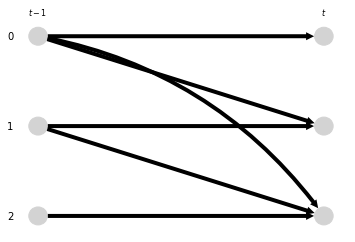


 REP 0 

 +++++ 
 vec 
 +++++
No NaN run 0
adag iteration =  0

 REP 1 

 +++++ 
 vec 
 +++++
No NaN run 0
adag iteration =  0

 REP 2 

 +++++ 
 vec 
 +++++
No NaN run 0
adag iteration =  0

 REP 3 

 +++++ 
 vec 
 +++++
No NaN run 0
adag iteration =  0

 REP 4 

 +++++ 
 vec 
 +++++
No NaN run 0
adag iteration =  0

 REP 5 

 +++++ 
 vec 
 +++++
No NaN run 0
adag iteration =  0

 REP 6 

 +++++ 
 vec 
 +++++
No NaN run 0
adag iteration =  0

 REP 7 

 +++++ 
 vec 
 +++++
No NaN run 0
adag iteration =  0

 REP 8 

 +++++ 
 vec 
 +++++
No NaN run 0
adag iteration =  0

 REP 9 

 +++++ 
 vec 
 +++++
No NaN run 0
adag iteration =  0

 REP 10 

 +++++ 
 vec 
 +++++
No NaN run 0
adag iteration =  0

 REP 11 

 +++++ 
 vec 
 +++++
No NaN run 0
adag iteration =  0

 REP 12 

 +++++ 
 vec 
 +++++
No NaN run 0
adag iteration =  0

 REP 13 

 +++++ 
 vec 
 +++++
No NaN run 0
adag iteration =  0

 REP 14 

 +++++ 
 vec 
 +++++
No NaN run 0
adag iteration =  0

 REP 15 

 +++++ 
 vec 
 +++++
No 

In [71]:
true_graphs, output_dict = adag_pca_savar(d_macro, d_micro, T, coeff, auto, contemp_frac,
                   pc_alpha, tau_min, tau_max,score_type, methods, data_gen,
                   savar_reps,sam)

In [38]:
# output_dict

# N = d_macro
# pred_graphs = np.array(output_dict['adag_pca_0.7'])
# output_dict['vec'][0]
# pred_graphs.shape

# graph_output = output_dict['adag_pca_0.7'][0]
# print(graph_output)
# tp.plot_time_series_graph(
#                         figsize=(6, 4),
#                         graph=graph_output,
#                         link_colorbar_label='MCI',
#                         ); plt.show()
# pcmci_sepsets(graph_output, tau_min = 1)

In [72]:
def _get_match_score(true_link, pred_link):
    if true_link == "" or pred_link == "": return 0
    count = 0
    # If left edgemark is correct add 1
    if true_link[0] == pred_link[0]:
        count += 1
    # If right edgemark is correct add 1
    if true_link[2] == pred_link[2]:
        count += 1
    return count
match_func = np.vectorize(_get_match_score, otypes=[int]) 
def _get_conflicts(pred_link):
    if pred_link == "": return 0
    count = 0
    # If left edgemark is conflict add 1
    if pred_link[0] == 'x':
        count += 1
    # If right edgemark is conflict add 1
    if pred_link[2] == 'x':
        count += 1
    return count
conflict_func = np.vectorize(_get_conflicts, otypes=[int]) 

def _get_unoriented(true_link):
    if true_link == "": return 0
    count = 0
    # If left edgemark is unoriented add 1
    if true_link[0] == 'o':
        count += 1
    # If right edgemark is unoriented add 1
    if true_link[2] == 'o':
        count += 1
    return count
unoriented_func = np.vectorize(_get_unoriented, otypes=[int]) 

In [73]:
def get_metrics(boot_samples, true_graphs, pred_graphs):
    
    _, N, N, _ = true_graphs.shape
    contemp_cross_mask_tril = np.zeros((N,N,tau_max + 1)).astype('bool')
    contemp_cross_mask_tril[:,:,0] = np.tril(np.ones((N, N)), k=-1).astype('bool')
    any_mask = np.ones((N,N,tau_max + 1)).astype('bool')
    any_mask[:,:,0] = contemp_cross_mask_tril[:,:,0]

    contemp_cross_mask_tril = np.repeat(contemp_cross_mask_tril.reshape(1, N,N,tau_max + 1), savar_reps, axis=0)
    any_mask = np.repeat(any_mask.reshape(1, N,N,tau_max + 1), savar_reps, axis=0)

    metrics_dict_savar = {}
    
    metrics_dict_savar['adj_anylink_precision'] = (((true_graphs!="")*(pred_graphs!="")*any_mask).sum(axis=(1,2,3)),
                            ((pred_graphs!="")*any_mask).sum(axis=(1,2,3)) )
    metrics_dict_savar['adj_anylink_recall'] = (((true_graphs!="")*(pred_graphs!="")*any_mask).sum(axis=(1,2,3)),
                            ((true_graphs!="")*any_mask).sum(axis=(1,2,3)) )
    # metrics_dict_savar['all_precision'] = ((((true_graphs=="-->")*(pred_graphs=="-->")+(true_graphs=="<--")*(pred_graphs=="<--"))*any_mask).sum(axis=(1,2,3)),
    #                         ((pred_graphs!="")*any_mask).sum(axis=(1,2,3)) )
    # metrics_dict_savar['all_recall'] = ((((true_graphs=="-->")*(pred_graphs=="-->")+(true_graphs=="<--")*(pred_graphs=="<--"))*any_mask).sum(axis=(1,2,3)),
    #                         ((true_graphs!="")*any_mask).sum(axis=(1,2,3)) )  
    # metrics_dict_savar['edgemarks_anylink_precision'] = ((match_func(true_graphs, pred_graphs)*any_mask).sum(axis=(1,2,3)),
    #                                                     2.*((pred_graphs!="")*any_mask).sum(axis=(1,2,3)) )
    # metrics_dict_savar['edgemarks_anylink_recall'] = ((match_func(true_graphs, pred_graphs)*any_mask).sum(axis=(1,2,3)),
    #                                                     2.*((true_graphs!="")*any_mask).sum(axis=(1,2,3)) )
    # metrics_dict_savar['unoriented_anylink'] = ((unoriented_func(true_graphs)*(any_mask)).sum(axis=(1,2,3)),
    #                                                     2.*((true_graphs!="")*any_mask).sum(axis=(1,2,3)) )
    # metrics_dict_savar['conflicts_anylink'] = ((conflict_func(pred_graphs)*(any_mask)).sum(axis=(1,2,3)),
    #                                                         2.*((pred_graphs!="")*any_mask).sum(axis=(1,2,3)) )


    for metric in metrics_dict_savar.keys():

        numerator, denominator = metrics_dict_savar[metric]

        metric_boot = np.zeros(boot_samples)
        for b in range(boot_samples):
            rand = np.random.randint(0, savar_reps, savar_reps)
            metric_boot[b] = numerator[rand].sum()/denominator[rand].sum()

        metrics_dict_savar[metric] = (numerator.sum()/denominator.sum(), metric_boot.std())
        
    return metrics_dict_savar

In [74]:
# metrics_dict_savar = get_metrics(boot_samples, true_graphs, pred_graphs)

boot_samples = 200
methods = ['vec', 'adag_pca_0.7']
output_graphs_per_method = [np.array(output_dict[method]) for method in methods]
all_metric_results = {x: dict() for x in methods}  #{y:{x: dict() for x in methods} for y in reg_range}


# [np.array(output_dict['vec']), np.array(output_dict['adag_pca_0.7'])]
for index, pred_graphs in enumerate(output_graphs_per_method) :

    all_metric_results[methods[index]] = get_metrics(boot_samples, true_graphs, pred_graphs)
    # print(metricss)

In [75]:
all_metric_results['vec']

{'adj_anylink_precision': (0.6704545454545454, 0.007977503362456083),
 'adj_anylink_recall': (0.9833333333333333, 0.017003063449468947)}

In [76]:
all_metric_results['adag_pca_0.7']

{'adj_anylink_precision': (1.0, 0.0),
 'adj_anylink_recall': (0.8333333333333334, 1.1102230246251565e-16)}

### More Experiments for SAVAR

In [528]:
def adag_pca_savar_edit(d_macro, d_micro, T, coeff, auto, contemp_frac,
                   pc_alpha, tau_min, tau_max,score_type, 
                   methods, data_gen,
                   savar_reps,sam,
                   range_nan = 7, #number of trials to find a score that isn't NaN
                   print_true_graph = True,
                   print_output_graph = False):
    
    output_dict = {x: list() for x in methods}
    
    data, true_graph = mech.data_savar(data_gen,d_macro,d_micro, sam, T, coeff, auto, contemp_frac, tau_max) 
    true_graphs = np.repeat(true_graph.reshape(1, d_macro,d_macro,tau_max + 1), savar_reps, axis=0)

    if print_true_graph == True:
        print('True Graph \n ==========')
        tp.plot_time_series_graph(
                    figsize=(6, 4),
                    graph=true_graph,
                    link_colorbar_label='MCI',
                    ); plt.show()

    for rep in range(savar_reps):
        print('\n ====== \n REP', rep,  '\n =======')
        for method in methods:
            for ir in range(range_nan):
                
                computation_time_start = time.time()
                if method == 'vec':   
                    print('\n +++++ \n vec \n +++++')
                    ############
                    # VEC-PC(MCI)
                    ############
                    
                    cond_ind_test = ParCorrMult(
                                        correlation_type = 'gcm_gmb',
                                        regularization_model = LinearRegression(),
                                        significance = 'shuffle_test',
                                        sig_blocklength=1,
                                        sig_samples=200)
                    
                    graph = vec_pcmci_no_contemp(data, d_macro, d_micro, cond_ind_test, tau_max, pc_alpha,tau_min)
                    output_dict[method].append(graph)
                    break

                elif 'adag_pca' in method:
                    ##################
                    # ADAG-PCA-PC(MCI)
                    ##################
                    score = 0
                    m= 0 
                    agg_method = "pca_1"
                    alpha = float(method.replace('adag_pca_',''))
                    # print('$\\alpha_q $ = ', alpha, '\n--------')    
                    print('No NaN run', ir)

                    while score < alpha and m<d_micro:
                        print("adag iteration = ",m)
                        data_agg, vector_vars = ff.agg_data_by_method(agg_method, data, d_micro, d_macro)
                        if m == 0:
                            vector_vars = None
                            ci_test = 'parcorr'
                        else:
                            ci_test = 'parcorr_gcm_gmb'

                        sepsets,p_matrix,graph,condsets = pcmci_aggscore_no_contemp(data_agg, pc_alpha, tau_max, tau_min = tau_min, vector_vars = vector_vars,ci_test=ci_test)
                        
                        if score_type == 'ind':
                            nom,den = ff.gen_comp_ind_score(data,p_matrix,sepsets, d_macro, d_micro, pc_alpha, ci_test='parcorr_gcm_gmb',tau_min=tau_min)
                        elif score_type == 'dep':
                            nom ,den = ff.gen_comp_dep_score(data, graph, condsets, d_macro, d_micro, pc_alpha, ci_test='parcorr_gcm_gmb',tau_min = tau_min)
                        elif score_type == 'AC':
                            nom_ind,den_ind = ff.gen_comp_ind_score(data,p_matrix,sepsets, d_macro, d_micro, pc_alpha, ci_test='parcorr_gcm_gmb',tau_min = tau_min)
                            nom_dep,den_dep = ff.gen_comp_dep_score(data, graph, condsets, d_macro, d_micro, pc_alpha, ci_test='parcorr_gcm_gmb',tau_min = tau_min)
                            nom, den = 1/2*(nom_ind+nom_dep) , 1/2*(den_ind+den_dep) 
                        else:
                            raise ValueError("Undefined Aggregation Consistency Score")
                            
                        print('nom, den', nom,den)

                        if den != 0:
                            score = float(nom/den)
                            # print('SCORE', score)
                            if score < alpha:
                                m += 1
                                agg_method = "pca_"+str(m)
                            else:
                                break

                        elif den == 0: #NaN condition
                            sam+=1000
                            break

                    if den != 0:
                        output_dict[method].append(graph)
                        break

        if print_output_graph == True:
            print('OUTPUT Graph', method, '\n ==========')
            tp.plot_time_series_graph(
                        figsize=(6, 4),
                        graph=graph,
                        link_colorbar_label='MCI',
                        ); plt.show()

        # output_dict[method].append(graph)
        

    return true_graphs, output_dict


In [549]:
d_macro = 3
d_micro = 49 #20
T = 200
coeff = 0.4
auto = 0.3
contemp_frac = 0.
pc_alpha = 0.01
tau_min = 1
tau_max = 1
score_type = 'ind'
methods = ['vec','adag_pca_0.8'] #['vec'] #['adag_pca_0.7'] # 'vec'
data_gen = 'savar'

savar_reps  = 100
sam =  42
# output_dict = {'vec':[], 'adag_pca_0.7':[]}

True Graph 


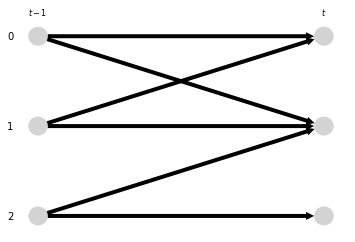


 REP 0 

 +++++ 
 vec 
 +++++
No NaN run 0
adag iteration =  0
nom, den 3 6
adag iteration =  1
nom, den 3 6
adag iteration =  2
nom, den 1 3
adag iteration =  3
nom, den 3 3

 REP 1 

 +++++ 
 vec 
 +++++
No NaN run 0
adag iteration =  0
nom, den 3 6
adag iteration =  1
nom, den 3 6
adag iteration =  2
nom, den 1 4
adag iteration =  3
nom, den 2 2

 REP 2 

 +++++ 
 vec 
 +++++
No NaN run 0
adag iteration =  0
nom, den 3 6
adag iteration =  1
nom, den 3 6
adag iteration =  2
nom, den 1 4
adag iteration =  3
nom, den 2 2

 REP 3 

 +++++ 
 vec 
 +++++
No NaN run 0
adag iteration =  0
nom, den 3 6
adag iteration =  1
nom, den 3 6
adag iteration =  2
nom, den 0 3
adag iteration =  3
nom, den 2 2

 REP 4 

 +++++ 
 vec 
 +++++
No NaN run 0
adag iteration =  0
nom, den 3 6
adag iteration =  1
nom, den 3 6
adag iteration =  2
nom, den 1 3
adag iteration =  3
nom, den 2 2

 REP 5 

 +++++ 
 vec 
 +++++
No NaN run 0
adag iteration =  0
nom, den 3 6
adag iteration =  1
nom, den 3 6
adag itera

In [550]:
true_graphs_new, output_dict_new = adag_pca_savar_edit(d_macro, d_micro, T, coeff, auto, contemp_frac,
                   pc_alpha, tau_min, tau_max,score_type, methods, data_gen,
                   savar_reps,sam)

In [551]:
# metrics_dict_savar = get_metrics(boot_samples, true_graphs, pred_graphs)

boot_samples = 200
methods = ['vec', 'adag_pca_0.8']
output_graphs_per_method = [np.array(output_dict_new[method]) for method in methods]
all_metric_results = {x: dict() for x in methods}  #{y:{x: dict() for x in methods} for y in reg_range}

for index, pred_graphs in enumerate(output_graphs_per_method) :

    all_metric_results[methods[index]] = get_metrics(boot_samples, true_graphs_new, pred_graphs)
    # print(metricss)

In [552]:
all_metric_results['vec']

{'adj_anylink_precision': (0.6621621621621622, 0.0019861055893561313),
 'adj_anylink_recall': (0.98, 0.00797245257119789)}

In [553]:
all_metric_results['adag_pca_0.8']

{'adj_anylink_precision': (0.8523391812865497, 0.001677563761276763),
 'adj_anylink_recall': (0.9716666666666667, 0.006733085804031052)}

In [554]:
def f1(precision, recall):
    return precision*recall/(precision+recall)

for method in methods:
    prec = all_metric_results[method]['adj_anylink_precision'][0]
    recall =all_metric_results[method]['adj_anylink_recall'][0]
    f1_score = f1(prec, recall)
    print(method, f1_score)

vec 0.3951612903225806
adag_pca_0.8 0.45404984423676015


### Tigramite Time Series Graph

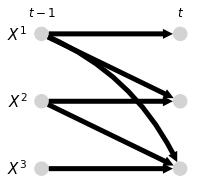

In [430]:
var_names = [r'$X^1$', r'$X^2$', r'$X^3$']
true_graph = true_graphs[0,:,:,:]

# tp.plot_graph(
#     graph=true_graph,
#     var_names=var_names,
#     link_colorbar_label='cross-MCI',
#     node_colorbar_label='auto-MCI',
#     show_autodependency_lags=False
#     ); plt.show()

tp.plot_time_series_graph(
    figsize=(3, 3),
    graph=true_graph,
    save_name = 'SAVAR_ts_graph', 
    link_width=None,
    arrow_linewidth=5,
    arrowhead_size=20,
    label_fontsize = 15, 
    alpha=1.,
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()


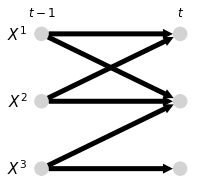

In [555]:
var_names = [r'$X^1$', r'$X^2$', r'$X^3$']
true_graph = true_graphs_new[0,:,:,:]

# tp.plot_graph(
#     graph=true_graph,
#     var_names=var_names,
#     link_colorbar_label='cross-MCI',
#     node_colorbar_label='auto-MCI',
#     show_autodependency_lags=False
#     ); plt.show()

tp.plot_time_series_graph(
    figsize=(3, 3),
    graph=true_graph,
    save_name = 'SAVAR_ts_graph_1', 
    link_width=None,
    arrow_linewidth=5,
    arrowhead_size=20,
    label_fontsize = 15, 
    alpha=1.,
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()


In [ ]:
true_graphs_new

#### Other parameters
plot_time_series_graph(
        graph,
        val_matrix=None,
        var_names=None,
        fig_ax=None,
        figsize=None,
        link_colorbar_label="MCI",
        save_name=None,
        link_width=None,
        link_attribute=None,
        arrow_linewidth=4,
        vmin_edges=-1,
        vmax_edges=1.0,
        edge_ticks=0.4,
        cmap_edges="RdBu_r",
        order=None,
        node_size=0.1,
        node_aspect=None,
        arrowhead_size=20,
        curved_radius=0.2,
        label_fontsize=10,
        tick_label_size=6,
        alpha=1.0,
        inner_edge_style="dashed",
        link_matrix=None,
        special_nodes=None,
        node_classification=None,
        # aux_graph=None,
        standard_color_links='black',
        standard_color_nodes='lightgrey',
)

In [437]:
output_dict

{'vec': [array([[['', '-->'],
          ['', '-->'],
          ['', '-->']],
  
         [['', '-->'],
          ['', '-->'],
          ['', '-->']],
  
         [['', '-->'],
          ['', '-->'],
          ['', '-->']]], dtype='<U3'),
  array([[['', '-->'],
          ['', '-->'],
          ['', '-->']],
  
         [['', '-->'],
          ['', '-->'],
          ['', '-->']],
  
         [['', '-->'],
          ['', '-->'],
          ['', '-->']]], dtype='<U3'),
  array([[['', '-->'],
          ['', '-->'],
          ['', '-->']],
  
         [['', '-->'],
          ['', '-->'],
          ['', '-->']],
  
         [['', '-->'],
          ['', '-->'],
          ['', '-->']]], dtype='<U3'),
  array([[['', '-->'],
          ['', '-->'],
          ['', '-->']],
  
         [['', '-->'],
          ['', '-->'],
          ['', '-->']],
  
         [['', '-->'],
          ['', '-->'],
          ['', '-->']]], dtype='<U3'),
  array([[['', '-->'],
          ['', '-->'],
          ['', '-->']],